In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import imodelsx.linear_finetune
from sasc import analyze_helper
import sasc.viz
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
import sasc.viz
dvu.set_style()


[2023-12-03 13:10:16,226] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [8]:
pilot_name = 'pilot2_story_data.pkl'
# pilot_name = 'pilot3_story_data.pkl'

stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot2_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20231106'

In [9]:
# load resps
polysemantic_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'polysemantic')[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in polysemantic_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

mats = defaultdict(list)
for use_clusters in [False]:
    for story_num in polysemantic_story_idxs:
        print(story_num, stories_data_dict["story_name_new"][story_num])
        rows = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                "_resps", "")
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        # paragraphs = story_data["story_text"][story_num].split("\n\n")
        # paragraphs = stories_data_dict["paragraphs"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # assert len(paragraphs) == len(rows)
        # print(
        #     "times",
        #     timing["time_running"].max(),
        #     "resp TRs",
        #     resp_story.shape[1],
        #     "doubled",
        #     resp_story.shape[1] * 2,
        # )
        resp_chunks = analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2
        )

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        # fill mat with nans
        mat[:] = np.nan

        print(f"{story_num=} {len(rows)=} {len(paragraphs)=} {len(resp_chunks)=}")
        # print(rows['expl1'])

        for i in range(len(paragraphs)):
            if i >= len(resp_chunks):
                mat[:, i] = np.nan
                break
            if use_clusters == False:
                mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(
                    axis=1)
            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        mat[:, -1] = np.nan  # ignore the last column
        # print('mat', mat)

        # sort by voxel_num
        args = np.argsort(rows["voxel_num"].values)
        mat = mat[args, :][:, args]
        # mat = mat[::2]  # only take even rows (since each row is duplicated)
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        plt.show()
rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(
        mats[use_clusters]
    )  # (num_stories, num_voxels, num_paragraphs)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

2 GenStory9_resps.npy
story_num=2 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=13
3 GenStory10_resps.npy
story_num=3 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=16



/tmp/ipykernel_2931649/2958126153.py:88: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

offset 0 16
mean 0.12278943116455088


['/home/chansingh/automated-explanations/results/processed/pilot2_poly_means.pkl']

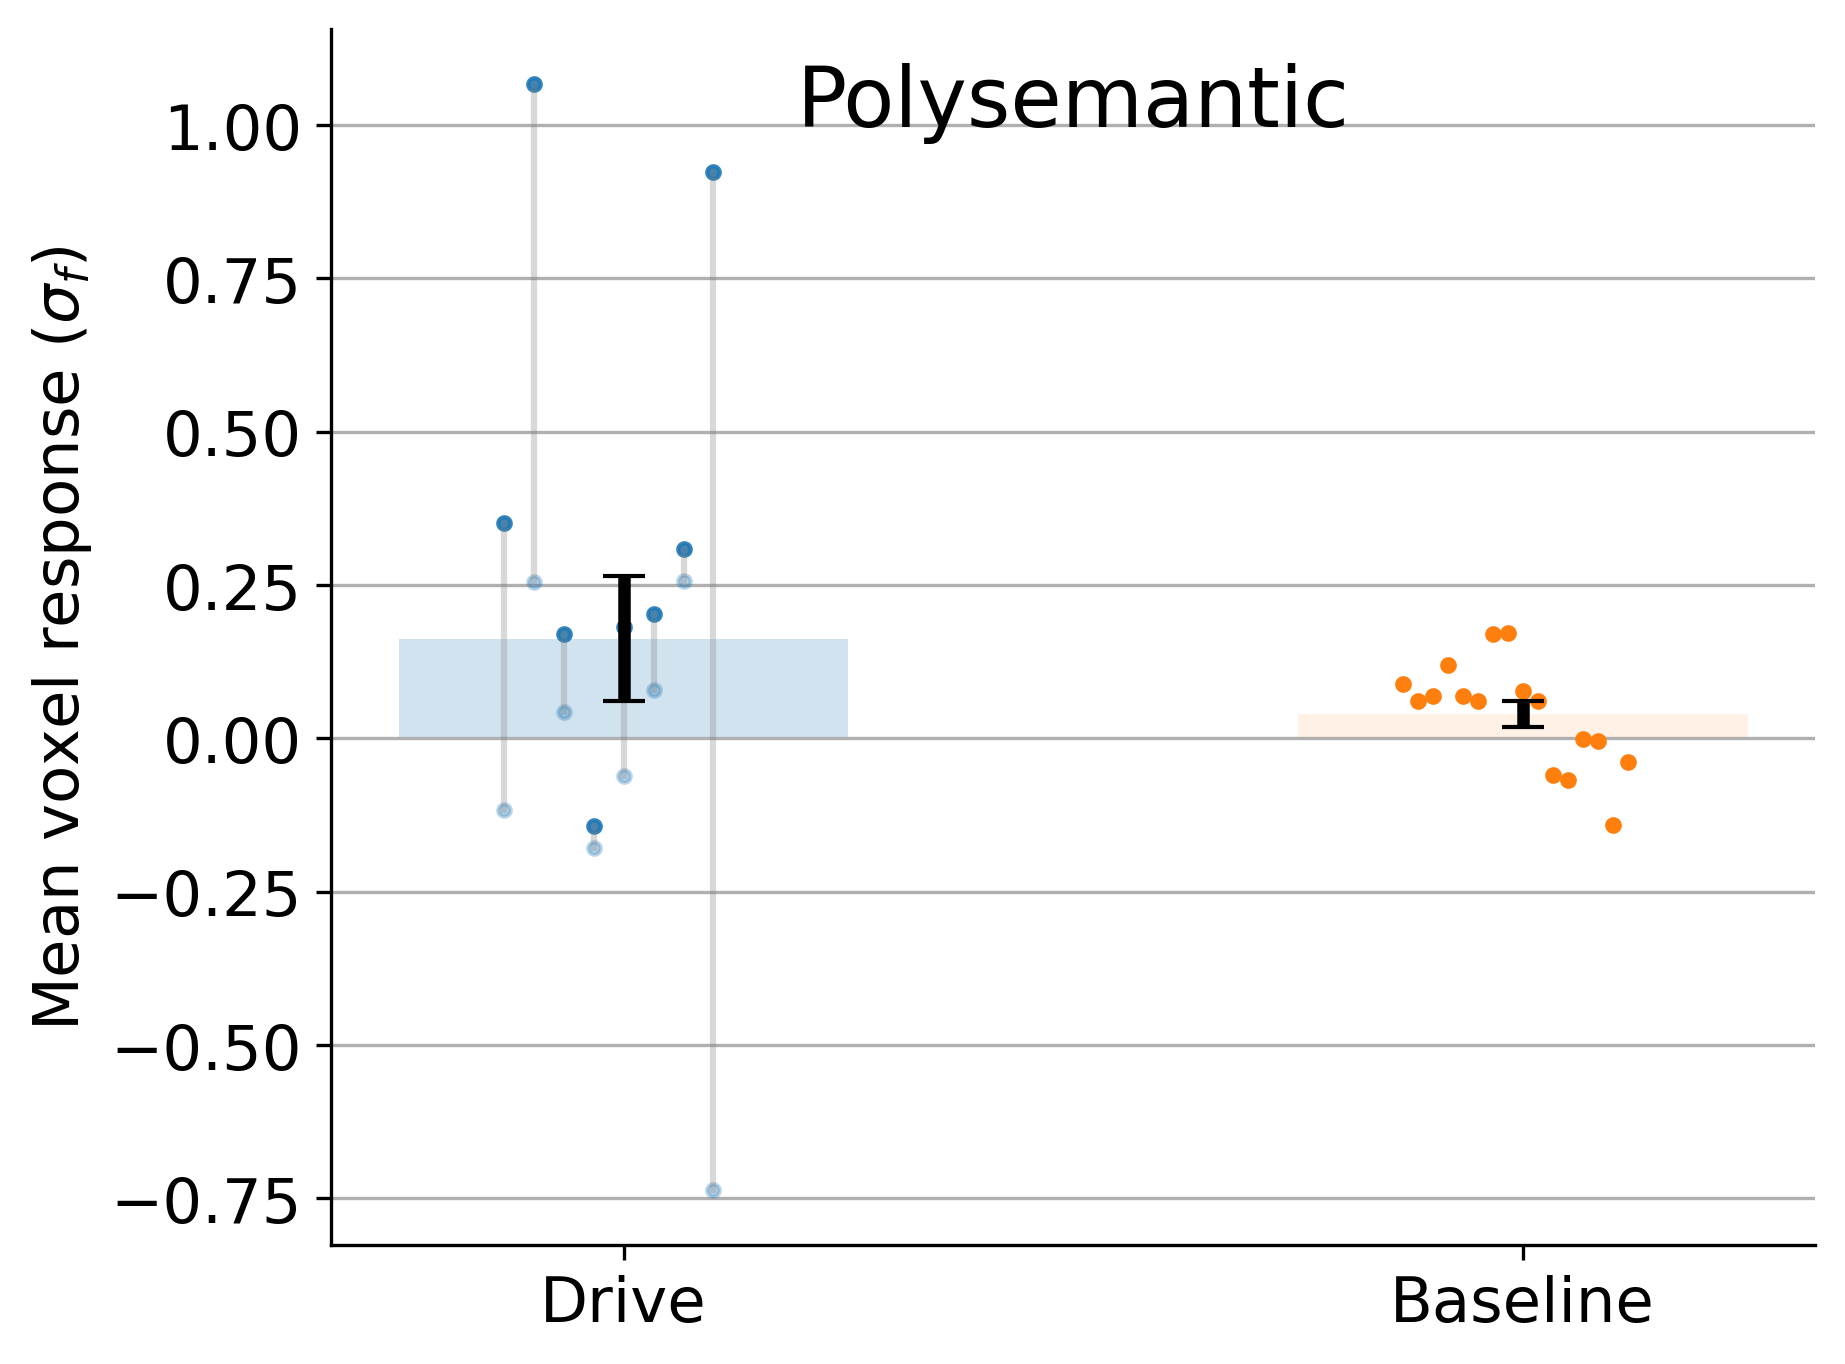

In [10]:
# calculate means
use_clusters = False
m1 = m[use_clusters]
diag_means = np.diag(m1)
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / len(diag_means))

sasc.viz.barplot_polysemantic([diag_means], [off_diag_means],
                              pilot_name, expls, annot_points=False)
joblib.dump({'diag_means': diag_means,
            'off_diag_means': off_diag_means}, join(RESULTS_DIR, 'processed', pilot_name.replace('_story_data.pkl', '_poly_means.pkl')))

### Relationship between different voxels

/tmp/ipykernel_2931649/3901427597.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(join(RESULTS_DIR, 'figs/main',
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


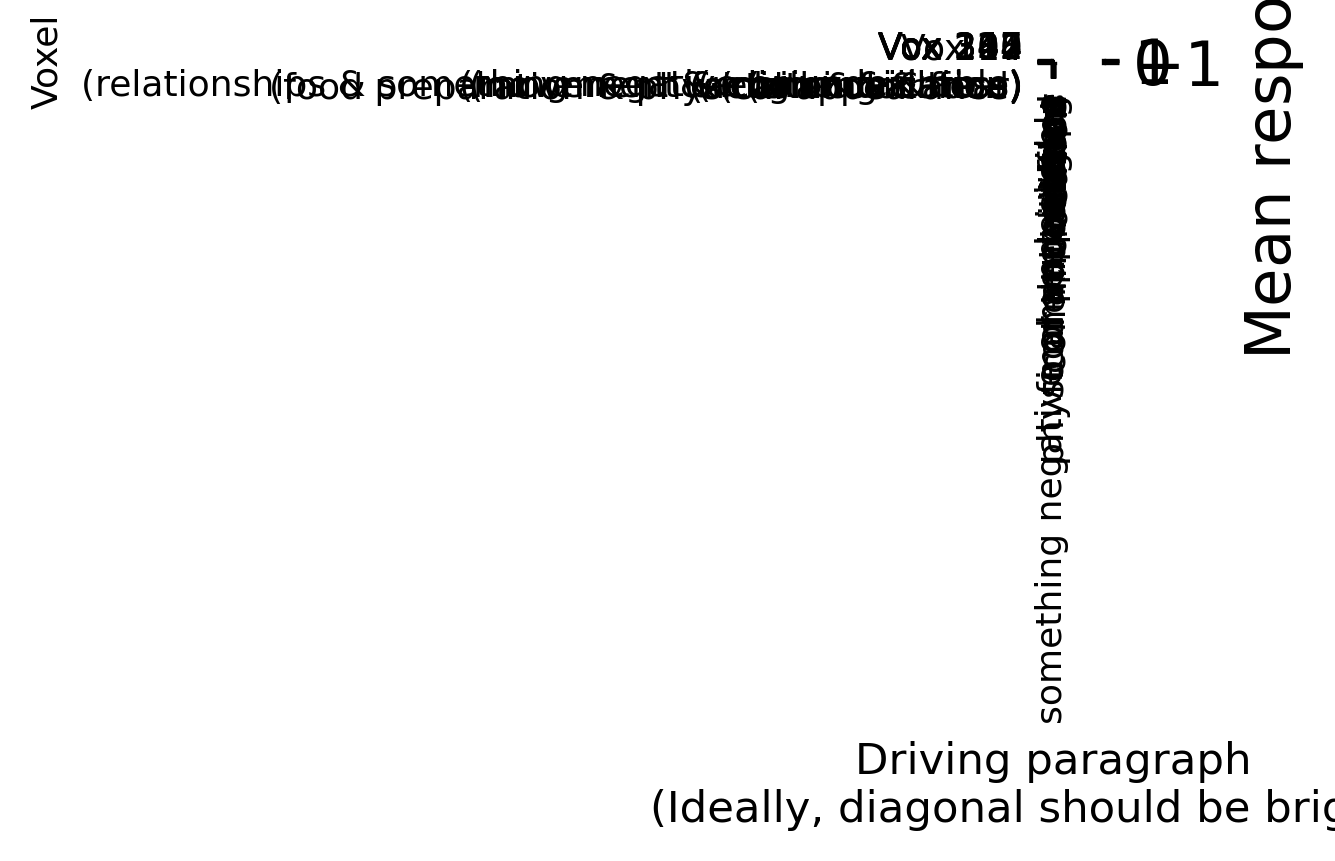

In [11]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]
# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
plt.figure(figsize=(6, 3), dpi=300)
# m = softmax(m, axis=0)

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=2)

# expls_order = analyze_helper.sort_expls_semantically(expls)
expls_order = np.arange(len(expls))
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
# m_plot = m1
sasc.viz.imshow_diverging(m_plot)
plt.xlabel(
    "Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize="x-small"
)
plt.ylabel("Voxel", fontsize="xx-small")
vox_names = []
for i in range(0, len(rows), 2):
    vox_names.append(
        "Vox "
        + str(rows["module_num"].values[i])
        + "\n("
        + rows["expl"].values[i]
        + ' & ' + rows["expl"].values[i + 1]
        + ")"
    )
# plt.yticks(labels=expls_with_num.values[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
plt.yticks(labels=vox_names, ticks=0.5 +
           np.arange(len(vox_names)) * 2, fontsize="xx-small")
plt.xticks(
    labels=expls[expls_order],
    ticks=np.arange(len(expls)),
    rotation=90,
    fontsize="xx-small",
)
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_poly_heatmap.pdf'))
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

### Story-level differences

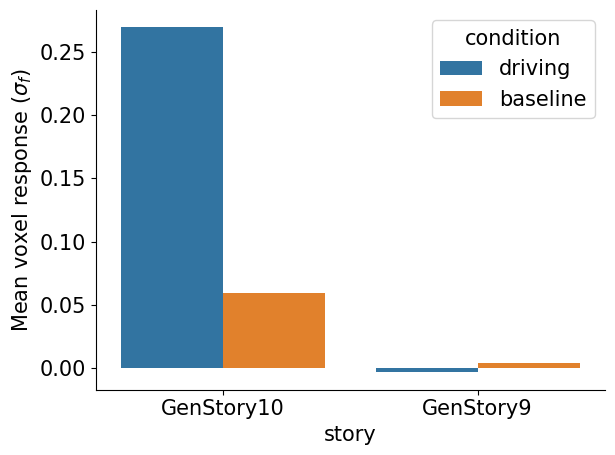

In [12]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
story_names = resp_np_files
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(story_names[i].replace('.npy', ''))

df = pd.DataFrame.from_dict(d)

joblib.dump(df, join(RESULTS_DIR, 'processed',
            pilot_name.replace('_story_data.pkl', '_poly_story_scores.pkl')))
sasc.viz.stories_barplot(df)

### Look into voxel trends

In [ ]:
rows["resp_driving"] = np.diag(m[use_clusters])
display(
    rows[["voxel_num", "expl", "roi_anat",
          "roi_func", "test_corr_new", "resp_driving"]]
    .sort_values(by="resp_driving", ascending=False)
    .round(2)
)
sns.lmplot(data=rows, x="test_corr_new", y="resp_driving")
plt.ylabel("Mean voxel response ($\sigma_f$), driving paragraphs")
plt.xlabel("Encoding performance (corr.) on new data")
plt.show()